## Linear Regression


Let's take a look at Linear Regression and its implementations in this notebook.

In [1]:
'''
If you are using Google Colab, uncomment the next line to download `utils_02.py`. 
'''
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_02_linear_reg/utils_02.py

'\nIf you are using Google Colab, uncomment the next line to download `utils_02.py`. \n'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

random_seed = 45

matplotlib.rcParams.update({'font.size': 16})

Time to generate features matrix $X$ and correct weights vector $w_{true}$. Targer vector (or matrix in general case) $Y$ is computed as  $X\mathbf{w}_{\text{true}}$ with gaussian noise:

In [19]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43
np.random.seed(random_seed+1)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# For different scales of features. In case of 3 features the code is equal to the commented line below
# X *= np.arange([1, 3, 5])[None, :]
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

*Recap:*
In case of linear model
$$
\hat{Y} = X\mathbf{w}
$$
and __MSE__ loss function
$$
Q(Y, X, \mathbf{w}) = MSE(Y, X\mathbf{w}) =  \|Y - X\mathbf{w}\|^2_2 = \sum_i (y_i - \mathbf{x}^T_i \mathbf{w})^2
$$
analytical solution takes simple form:

$$
\mathbf{w}^* = (X^T X)^{-1}X^T Y.
$$

_To do: derive it on the practice session._

Let's check how it works:

In [20]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [21]:
w_star

array([0.59054644, 1.23044047])

In [22]:
w_true

array([0.58487584, 1.23119574])

As we can see, the analytical solution is quite close to the original one. 

Now let's generate the dataset with correlated features:

In [62]:
n_features = 3
n_objects = 300
batch_size = 10
num_steps = 43
eps = 1e-3

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# Now we duplicate the second feature with some small noise, so featues 2 and 3 are collinear
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))

In [73]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([ -0.40979459,  35.18332853, -36.65086199])

In [78]:
_X = X[1:]
_w_star = np.linalg.inv(_X.T.dot(_X)).dot(_X.T).dot(Y[1:])
_w_star

array([ -0.41481728,  56.05903521, -57.53069893])

In [76]:
w_true

array([-0.39514554, -0.20430091, -1.27163265])

In [77]:
w_star[1:].sum()

-1.4675334665625428

In [55]:
w_true[1:].sum()

-0.8563631037988879

As we can see, the second and third coefficents are opposite. This makes our model highly *unstable*.

How could one actually fix it? Here comes the __regularization__.

Let's use the L2 norm of weigths vector as a regularization term to constrain the desired solution.

$$
Q_{\text{reg}}(Y, X, \mathbf{w}) = MSE(Y, X\mathbf{w}) + \lambda\|\mathbf{w}\|_2^2=  \|Y - X\mathbf{w}\|^2_2 + \lambda\|\mathbf{w}\|^2_2= \sum_i (y_i - \mathbf{x}^T_i \mathbf{w})^2 + \sum_p w^2_p
$$

Analytical solution is available in this case as well:

$$
\mathbf{w}^*_{\text{reg}} = (X^T X + \lambda I_p)^{-1}X^T Y,
$$
where $I_p$ is diagonal matrix consisting of 1s (with size p).

__Be careful with the regularization term if you have included the column of 1s into X matrix! We do not want regularize the bias (free) term in our linear model.__

In [56]:
w_star_reg = np.linalg.inv(X.T.dot(X) + 0.05*np.eye(n_features)).dot(X.T).dot(Y)
w_star_reg

array([ 0.81856465, -0.56904305, -0.29321512])

In [57]:
w_true[1:].sum()

-0.8563631037988879

In [58]:
w_star_reg[1:].sum()

-0.8622581626339355

### Gradient descent

The analytical solution described above includes invertion of the matrix $X^T X$ (or $X^T X + \lambda I$), which is quite expensive in terms of computation resourses. The complexity of matrix inversion can be estimated as $O(p^3 + p^2 N)$. This leads us to the iterative optimization methods, which are more efficient and are de-facto the main approach to optimization in Machine Learning.

Gradient descent is one of the most popular optimization methods. Worth to mention the fact that the minimization (maximization) target (e.g loss function value) should be differentiable w.r.t model parameters. Using the gradient descent, the weights vector $\mathbf{w}^{(t+1)}$ on step $t+1$ can be expressed in the following form:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta_t \nabla Q(\mathbf{w}^{(t)}),
$$
where $\eta_t$ stays for the gradient step (usually referred as _learning rate_).

The gradient in case of MSE loss function takes the following form:

$$
\nabla Q(\mathbf{w}) = -2X^TY + 2X^TX\mathbf{w} = 2X^T(X\mathbf{w} - Y).
$$

In this case the complexity is only $O(pN)$. To make it even more effective (and using the hypothesis of homogeneous data in the dataset) one could use _stochastic gradient descent_, which computes the gradient only over some random subset of data K points, so the final complexity decreases to $O(pK)$, where $K << N$.

### Visuailizing the gradient descent trajectory
This part is deeply based on [Evgeny Sokolov](https://github.com/esokolov) open materials.

Let's take a close look on the optimization path in simple two-dimentional space (where features are in different scales). We will use MSE loss function.

The plots below show $\mathbf{w}^{(t)}$ values on every step $t$. The red dot in the center stays for $\mathbf{w}_{\text{true}}$.

In [59]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43
np.random.seed(random_seed)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# For different scales of features. In case of 3 features the code is equal to the commented line below
# X *= np.arange([1, 3, 5])[None, :]
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

In [60]:
np.random.seed(random_seed)
w_0 = np.random.uniform(-2, 2, n_features)-0.5
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= step_size * 2. * np.dot(X.T, (X.dot(w) - Y)) / Y.size # YOUR CODE HERE
    w_list.append(w.copy())
w_list = np.array(w_list)

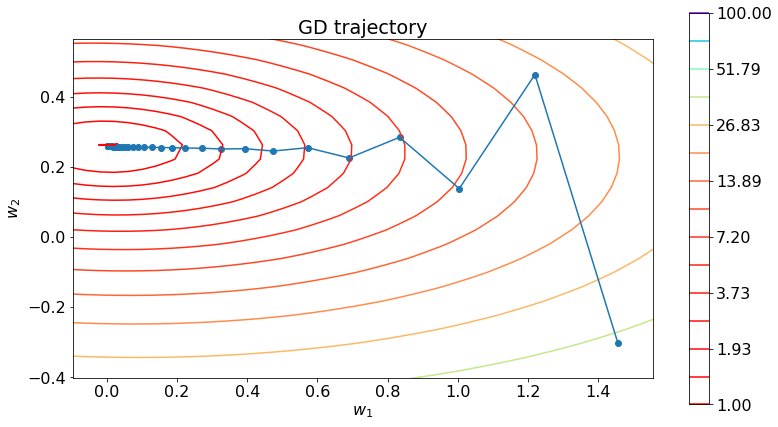

In [61]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=15), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### Instability analysis
Using the new technique, let's analyse the linear regression behavior in case of multicollinear features.

In case of (multi-)collinear features the solution is *unstable*. Let's take a look at the *condition number* of our matrix:
$$\kappa(a) = \frac{\sigma_\max(A)}{\sigma_\min(A)}$$
where $\sigma _{\max }(A)$ and $\sigma _{\min }(A)$ are maximal and minimal singular values of matrix $A$ respectively. Hence 

In [79]:
def get_w_by_grad(X, Y, num_steps, w_0, lr):
    w = w_0.copy()

    for i in range(num_steps):
        w -= 2 * lr * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    return w

def get_w_by_stoch_grad(X, Y, num_steps, w_0, lr_0, n_objects):
    w = w_0.copy()
    lr_0 = 0.45

    for i in range(num_steps):
        lr = lr_0 / ((i+1)**0.51)
        sample = np.random.randint(n_objects, size=batch_size)
        w -= 2 * lr * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    return w

def rmse(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred)

In [80]:
lr = 1e-3
sgd_lr = 0.1
num_steps = 250
noise_eps_seq = np.logspace(-2, -6, 20)

w_0 = np.random.uniform(-2, 2, (n_features))

In [81]:
condition_numbers = []
vector_norms_list = []
rmse_list = []
results_list = []
for eps in noise_eps_seq:
    local_condition_numbers = []
    local_vector_norms_list = []
    local_rmse_list = []
    for i in range(50):
        X[:, -1] = 2 * (X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape))

        a = np.linalg.eigvals(X.T.dot(X))
        local_condition_numbers.append(a.max() / a.min())

        w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        w_star_grad = get_w_by_grad(X, Y, num_steps, w_0, lr)
        w_star_sgd = get_w_by_stoch_grad(X, Y, num_steps, w_0, sgd_lr, n_objects)
        local_vector_norms_list.append([
            np.linalg.norm(w_star),
            np.linalg.norm(w_star_grad), 
            np.linalg.norm(w_star_sgd),
        ])

        analytical_predict = X.dot(w_star)
        grad_predict = X.dot(w_star_grad)
        sgd_predict = X.dot(w_star_sgd)
        
        local_rmse_list.append([
            rmse(Y, analytical_predict),
            rmse(Y, grad_predict),
            rmse(Y, sgd_predict),
        ])
        
        results_list.append([w_star, w_star_grad, w_star_sgd])

    condition_numbers.append([np.mean(local_condition_numbers), np.std(local_condition_numbers)])
    vector_norms_list.append([
        np.mean(np.array(local_vector_norms_list), axis=0),
        np.std(np.array(local_vector_norms_list), axis=0),
    ])
    rmse_list.append(np.mean(np.array(local_rmse_list), axis=0))

condition_numbers = np.array(condition_numbers)
vector_norms_list = np.array(vector_norms_list)
rmse_list = np.array(rmse_list)

Take a close look on the collected vectors:

In [82]:
from utils_02 import visualise

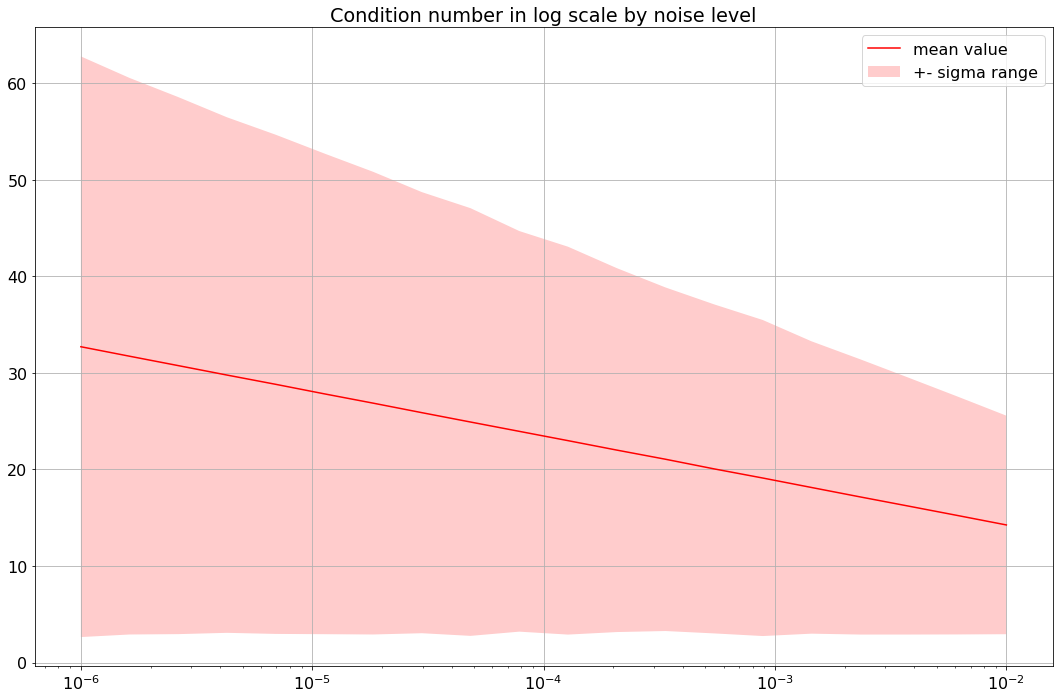

In [83]:
visualise(
    np.log(condition_numbers[:, 0]), 
    np.log(condition_numbers[:, 1]),
    noise_eps_seq, 
    title='Condition number in log scale by noise level',
    greater_than_zero=True,
    log_scale=True
)

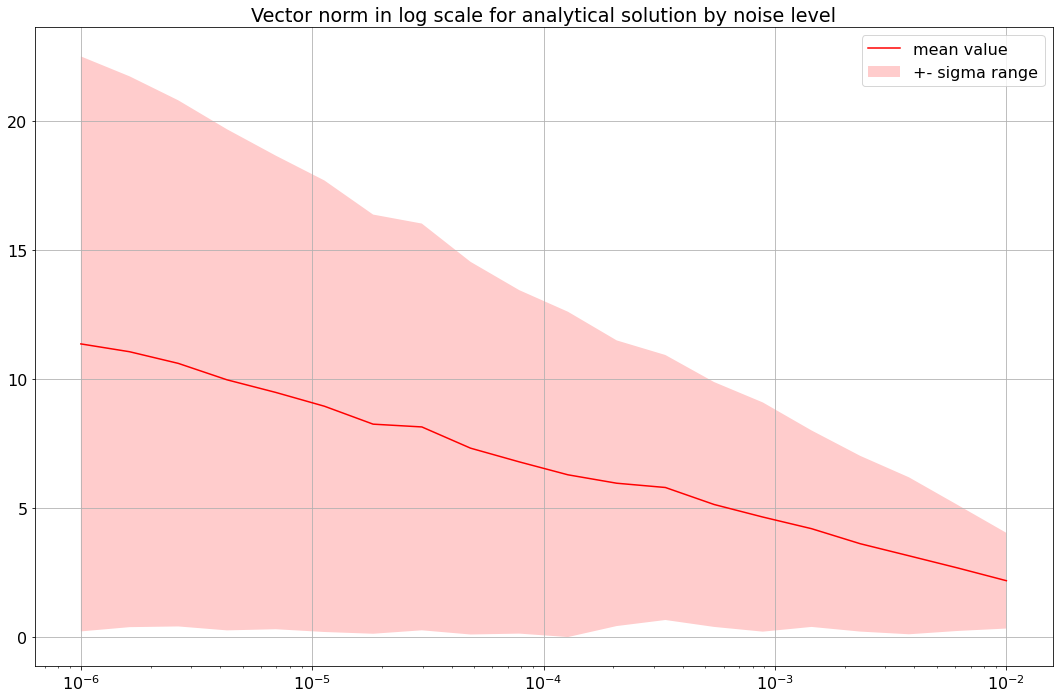

In [84]:
visualise(
    np.log(vector_norms_list[:, 0, 0]), 
    np.log(vector_norms_list[:, 1, 0]),
    noise_eps_seq, 
    title='Vector norm in log scale for analytical solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

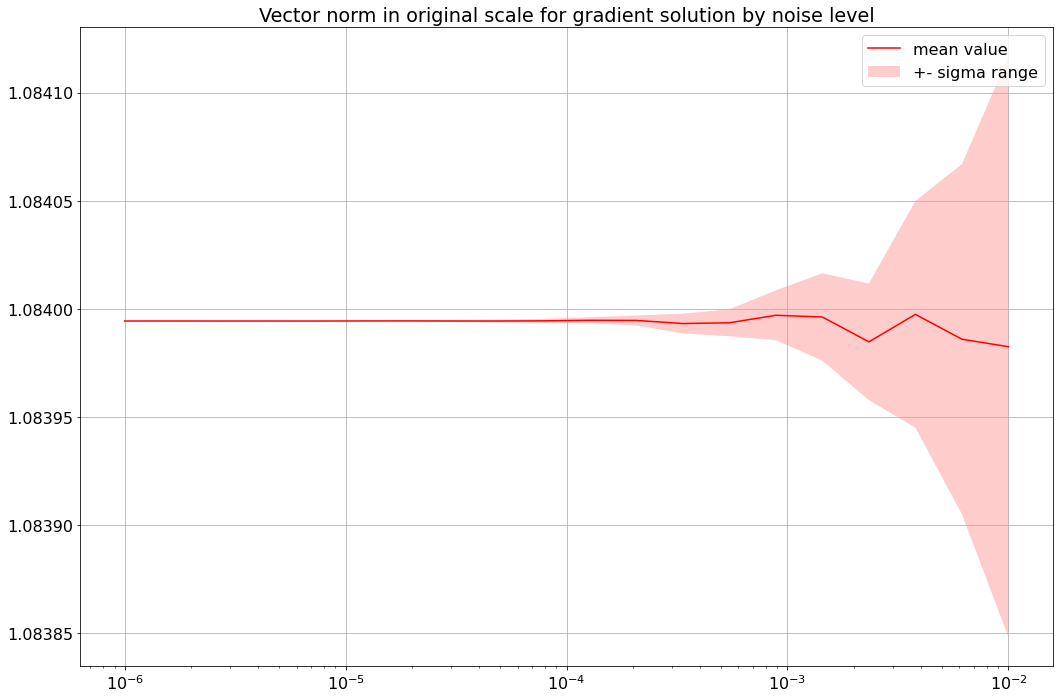

In [85]:
visualise(
    vector_norms_list[:, 0, 1], 
    vector_norms_list[:, 1, 1],
    noise_eps_seq, 
    title='Vector norm in original scale for gradient solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

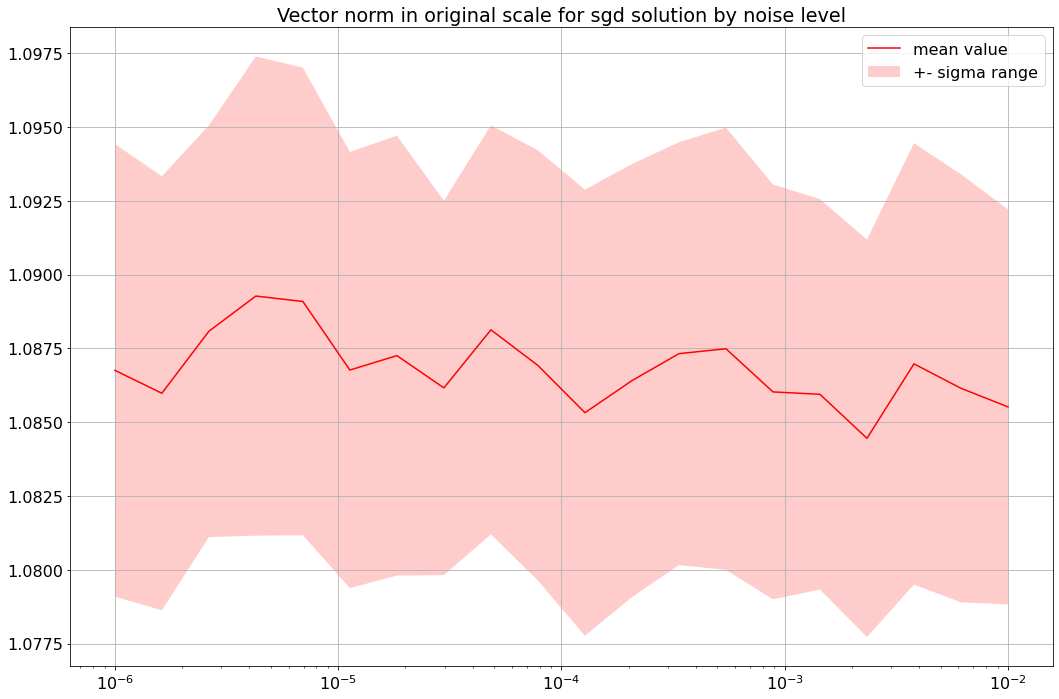

In [86]:
visualise(
    vector_norms_list[:, 0, 2], 
    vector_norms_list[:, 1, 2],
    noise_eps_seq, 
    title='Vector norm in original scale for sgd solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

## Linear regression out of the box

Finally, let's take a brief look at implemented versions of Linear Regression from sklearn. The main classes are:

* [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) — classical linear regression (*actially, it is just `scipy.linalg.lstsq` wrapped with sklearn `Predictor` class) __analytical__ solver.
* [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) — Linear regression with L1 regularization.
* [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) — Linear regression with L2 regularization.

To minimize any other error function you are free to use [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) (or wait for a week and we will get the great *PyTorch* automatic differentiation engine).

Let's compare the speed of analytical and gradient solutions from the sklearn realizations.

IPython magic `%%time` wrapper will be used.

To measure the quality $R^2$ score will be used. It compares our model (`a`) with one always predicting mean `y`:

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$

`LinearRegression` vs. `Ridge`: __Fight!__



In [87]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [98]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [94]:
%%time

lr = LinearRegression()
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999676618116351
CPU times: user 1min 34s, sys: 4.63 s, total: 1min 38s
Wall time: 19.9 s


In [99]:
%%time

lr = Ridge(alpha=0.0, solver='sparse_cg')
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999679640441261
CPU times: user 1.33 s, sys: 192 ms, total: 1.53 s
Wall time: 612 ms


## Own neat version of Linear Regression

Let's use `sklearn`'s standard interfaces to implement sealed version of our version of Linear Regression using SGD

First we need to inherit base classes, then implement 3 main stages of regressor life as methods:
* hyperparameter initialization - constructor
* parameters training on known objects - fit method
* target estimation for unknown objects - predict method

In [100]:
from sklearn.base import BaseEstimator, RegressorMixin
# also ClassifierMixin and TransformerMixin exist

In [101]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    '''LinearRergession with L2 regularization and SGD optimizer
    '''
    def __init__(
        self, C: float=1.0,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=200,
    ) -> None:
        self.C = C
        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        # this is just copied from above
        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / self.batch_size

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

Let's generate dataset with differently scaled features

In [102]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

and split it to train and test

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

Now let's test our solution

In [105]:
own_lr = LinearRergessionSGD().fit(x_train, y_train)
print(f'R2: {own_lr.score(x_test, y_test)}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

OOOOOOOOOPS!!!

Something went wrong. What could it be?

During our SGD we've encountered too big values to store in float.

That leads us to feature normalization.
Lest's scale features: just subtract mean from each feature and divide by sample variation

In [126]:
x_scaled_by_hands = (x_train - x_train.mean(axis=0, keepdims=True)) / (x_train.std(axis=0, keepdims=True) + 1e-5)

In [127]:
np.allclose(x_scaled, x_scaled_by_hands, atol=1e-5)

True

In [108]:
from sklearn.preprocessing import StandardScaler

In [110]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)

In [134]:
own_lr = LinearRergessionSGD().fit(x_scaled, y_train)

But for test we need to scale test features

In [135]:
x_test_scaled = scaler.transform(x_test)

In [137]:
print(f'R2: {own_lr.score(x_test_scaled, y_test)}')

R2: 0.9965142196068342


Wow! we didn't implement no `score` method. But `sklearn`'s base class provide us it aleready implemented.

You note that scaling data before prediction is not a big pleasure. So we could get rid of this bulkiness with pipelines

In [138]:
from sklearn.pipeline import make_pipeline

In [139]:
pipe = make_pipeline(
    StandardScaler(),
    LinearRergessionSGD(),
)

In [140]:
pipe.fit(x_train, y_train)
print(f'R2: {pipe.score(x_test, y_test)}')

R2: 0.9964865310951883


As if we don't have any complex assembly behind pipeline interface!

And no data leak guaranteed as a gift!